input_image = "book3.png"
output_width = 900
tolerance=12
img = Image.open(input_image)
if img.size[0] >= 900:
    wpercent = (output_width/float(img.size[0]))
    hsize = int((float(img.size[1])*float(wpercent)))
    img = img.resize((output_width,hsize), Image.LANCZOS)
    resize_name = 'resize_'+ input_image
    img.save(resize_name)
else:
    resize_name = input_image
    
img_url = resize_name
colors_x = extcolors.extract_from_path(img_url, tolerance = tolerance, limit = 13)
df_color = color_to_df(colors_x)

In [125]:
import param 
import panel as pn
from panel.template.base import _base_config

from PIL import Image

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
import cv2
import extcolors
import colorsys
from colormap import rgb2hex
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [185]:
def color_to_df(input):
    color_df = pd.DataFrame(input[0], columns = ['val', 'inc'])
    color_df['r'], color_df['b'], color_df['g'] = color_df.val.str
    color_df['hsv'] = [colorsys.rgb_to_hsv(color_df['r'][i]/255, color_df['b'][i]/255, color_df['g'][i]/255) for i in color_df.index]
    color_df['h'], color_df['s'], color_df['v'] = color_df.hsv.str
    color_df['hue_angle'] = color_df['h']*360
    color_df['c_code']=[rgb2hex(color_df['r'][i], color_df['b'][i], color_df['g'][i]) for i in color_df.index]
    color_df['approved'] = color_df['hue_angle'].map(lambda x: "Yes" if (x>= 76) & (x<=225) else "No")                                           
    return color_df[['c_code','hue_angle', 's','v','approved']]

In [203]:
def extract_color(input_image, resize, tolerance):
    '''function takes an image file and several parameters, and returns a list of the colors detected in the image''' 
    #background
    bg = 'bg.png'
    fig, ax = plt.subplots(figsize=(192,108),dpi=10)
    fig.set_facecolor('white')
    plt.savefig(bg)
    plt.close(fig)
    
    #resize
    output_width = resize
    img = Image.open(input_image)
    if img.size[0] >= resize:
        wpercent = (output_width/float(img.size[0]))
        hsize = int((float(img.size[1])*float(wpercent)))
        img = img.resize((output_width,hsize), Image.LANCZOS)
        resize_name = 'resize_'+ input_image
        img.save(resize_name)
    else:
        resize_name = input_image
    
    #crate dataframe
    img_url = resize_name
    colors_x = extcolors.extract_from_path(img_url, tolerance = tolerance, limit=12)
    df_color = color_to_df(colors_x)
    
    #color palette
    
    bg = plt.imread('bg.png')
    fig = plt.figure(figsize=(90, 90), dpi = 10)
    ax = fig.add_subplot(1,1,1)
    
    list_color = list(df_color['c_code'])
    x_posi, y_posi, y_posi2 = 320, 25, 25    
    
    #Update the labels to instead of showing the hex code, show the Approval value
    #Update to include a title/header
    
    for c in list_color:
        if  list_color.index(c) <= 5:
            y_posi += 125
            rect = patches.Rectangle((x_posi, y_posi), 290, 115, facecolor = c)
            ax.add_patch(rect)
            ax.text(x = x_posi+360, y = y_posi+80, s = c, fontdict={'fontsize': 150})
        else:
            y_posi2 += 125
            rect = patches.Rectangle((x_posi + 800, y_posi2), 290, 115, facecolor = c)
            ax.add_artist(rect)
            ax.text(x = x_posi+1160, y = y_posi2+80, s = c, fontdict={'fontsize': 150})

    ax.axis('off')
    plt.imshow(bg)       
    plt.tight_layout()
    plt.close()
    return fig

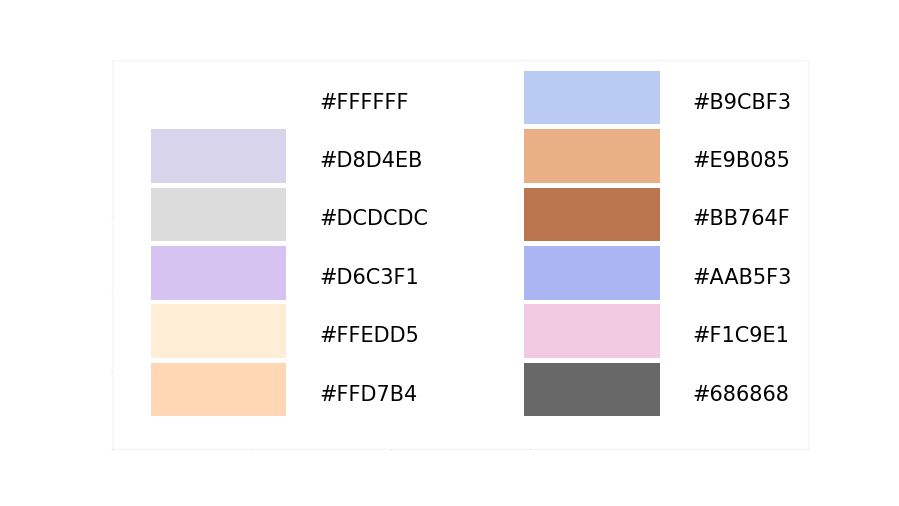

In [204]:
extract_color("book1.jpg", 900, 12)

In [146]:
pn.extension()

In [212]:
def validate_options(event=None):
    #get values from inputs
    sleeve = sleeve_length.value 
    neck = neckline.value
    outer = outer_layer.value
    hem = bottom_length.value
    
    #logic to evaluate outfit
    issue_list = []
    if sleeve in ['Long', '3/4 length']:
        s=1
    elif sleeve in ['Short', 'Cap', 'None']:
        if outer=="True":
            s=1
        else: 
            s=0
            issue_list.append("Shoulders and biceps need to be covered. Please adjust your plan.")
    else:
        s=0
        issue_list.append("Shoulders and biceps need to be covered. Please adjust your plan.")
    
    if neck in ['Deep V', 'Other']:
        n=0
        issue_list.append("Modest necklines are required. If you chose 'Other', please confirm with leadership about your planned outfit.")
    else:
        n=1
    
    if hem in ['Mid-thigh', 'Knee']:
        h=0
        issue_list.append("Hem lines need to be at the knee or lower. If you chose 'Knee', please confirm with leadership about your planned outfit.")
    else:
        h=1
    
    if s+n+h==3:
        response = "Looking good!"
    else:
        response = '<br>'.join(map(str,issue_list))
    
    output_response.value = response
    
    if color_check.value is not None:
        i_fn = 'image.'+color_check.mime_type.split('/')[1]
        color_check.save(i_fn)
        figure = extract_color(i_fn, 900, 12)
        pallette.object=figure    


Column
    [0] Row
        [0] Column
            [0] Markdown(str)
            [1] Markdown(str)
            [2] RadioBoxGroup(name='Sleeve length', options=['Long', '3/4 length', ...], value='Long')
            [3] Markdown(str)
            [4] RadioBoxGroup(name='Neckline', options=['Collared', 'Scoop', ...], value='Collared')
            [5] Markdown(str)
            [6] RadioBoxGroup(inline=True, name='Outer layer?', options=['True', 'False'], value='True')
        [1] Column
            [0] Markdown(str)
            [1] Markdown(str)
            [2] RadioBoxGroup(name='Bottom length', options=['Mid-thigh', ...], value='Mid-thigh')
            [3] Spacer()
            [4] Spacer()
            [5] Spacer()
            [6] Markdown(str)
            [7] Markdown(str)
            [8] FileInput(accept='.png,.jpg')
    [1] Row
        [0] Button(button_type='primary', name='Evaluate outfit p...)
        [1] StaticText(name='Your outfit')
    [2] Spacer()
    [3] Spacer()
    [4] Row
        [0] Matplotlib(Figure, height=345, sizing_mode='scale_height', tight=True, width=460)
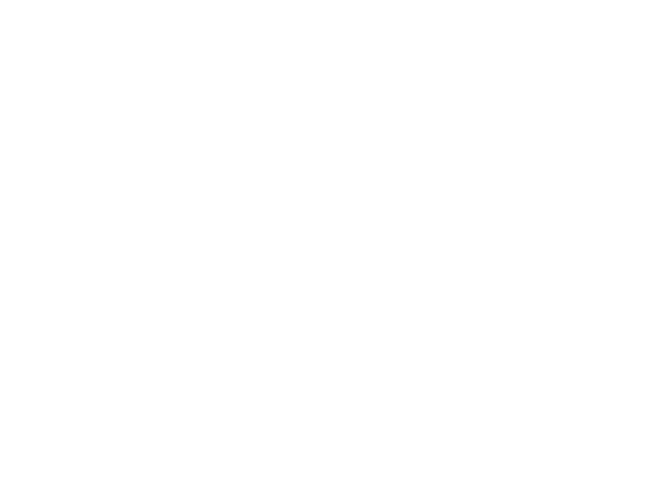

In [221]:
sleeve_length = pn.widgets.RadioBoxGroup(name='Sleeve length', options=['Long', '3/4 length', 'Short', 'Cap', 'None'], inline=False)
neckline = pn.widgets.RadioBoxGroup(name='Neckline', options=['Collared', 'Scoop', 'Modest V', 'Deep V', 'Other'], inline=False)
outer_layer = pn.widgets.RadioBoxGroup(name='Outer layer?', options=['True', 'False'], inline=True)
bottom_length = pn.widgets.RadioBoxGroup(name='Bottom length', options=['Mid-thigh', 'Knee', 'Mid-calf', 'Ankle'], inline=False)
color_check = pn.widgets.FileInput(accept='.png,.jpg')
evaluate_button = pn.widgets.Button(name="Evaluate outfit parameters", button_type = "primary")
output_response = pn.widgets.StaticText(name="Your outfit", value='')
fig0 = plt.figure()
plt.close()
pallette = pn.pane.Matplotlib(fig0, tight=True, sizing_mode="scale_height")
evaluate_button.on_click(validate_options)

layout = pn.Column(
                pn.Row(pn.Column("<b>Attributes of Top of Outfit</b>", 
                                 "Sleeve length", sleeve_length, "Neckline", neckline, 
                                 "Are you planning to wear an outer layer (cardigan/sweater)?", outer_layer),
                       pn.Column("<b>Attributes of Bottom of Outfit</b>", 
                                 "Where does the hemline of the bottom of your outfit hit?", bottom_length,
                                 pn.Spacer(), pn.Spacer(), pn.Spacer(),
                                 "<b>Non-neutral color checking</b>",
                                 "Upload a jpg or png file with a picture of the blue and green colors you plan on wearing for a color pallette check.", color_check)
                      ), 
                pn.Row(evaluate_button, output_response),
                pn.Spacer(), pn.Spacer(),
                pn.Row(pallette)
        )

layout

FastListTemplate
    [js_area] HTML(None, height=0, margin=0, sizing_mode='fixed', width=0)
    [actions] TemplateActions()
    [busy_indicator] LoadingSpinner(height=20, width=20)
    [2318312037072] Markdown(str)
    [2318238040016] Column
        [0] Row
            [0] Column
                [0] Markdown(str)
                [1] Markdown(str)
                [2] RadioBoxGroup(name='Sleeve length', options=['Long', '3/4 length', ...], value='Long')
                [3] Markdown(str)
                [4] RadioBoxGroup(name='Neckline', options=['Collared', 'Scoop', ...], value='Collared')
                [5] Markdown(str)
                [6] RadioBoxGroup(inline=True, name='Outer layer?', options=['True', 'False'], value='True')
            [1] Column
                [0] Markdown(str)
                [1] Markdown(str)
                [2] RadioBoxGroup(name='Bottom length', options=['Mid-thigh', ...], value='Mid-thigh')
                [3] Spacer()
                [4] Spacer()
                [5] Spacer()
                [6] Markdown(str)
                [7] Markdown(str)
                [8] FileInput(accept='.png,.jpg', filename='book3.png', mime_type='image/png', value=b'\x89PNG\r\n\x1a\n\x00\x0...)
        [1] Row
            [0] Button(button_type='primary', clicks=1, name='Evaluate outfit p...)
            [1] StaticText(name='Your outfit', value="Hem lines need to be at t...)
        [2] Spacer()
        [3] Spacer()
        [4] Row
            [0] Matplotlib(Figure, height=345, tight=True, width=6480)
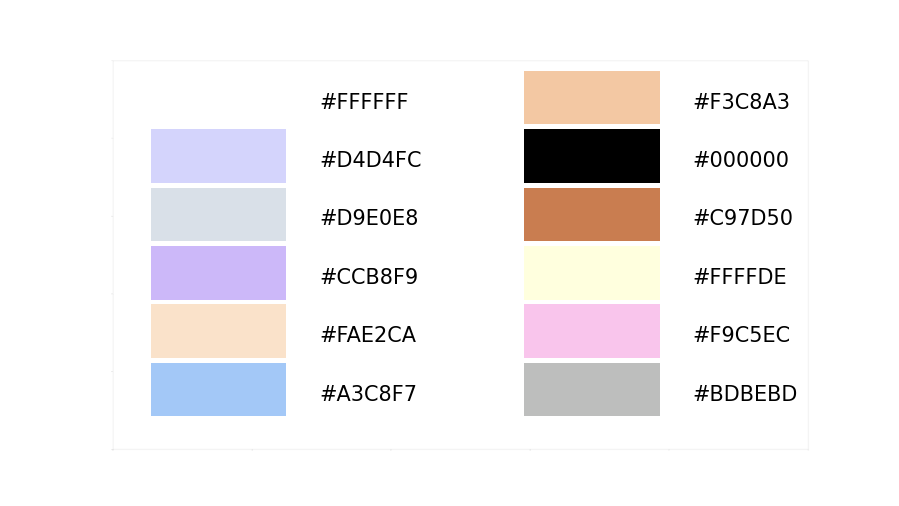

In [216]:
pn.template.FastListTemplate(
    title = "Voices of Symphony Tacoma Dress Code Validation", header_background="#00C3CC", theme_toggle=False,
    accent_base_color = "#00C3CC",
    main = ["This page will help you confirm if you outfit choices fit within the parameters for our new dress code.",
            layout,
           ], main_max_width='300px',)